# Financial Risk Assessment Using Logistic Regression 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)


In [2]:
#  Load the dataset
df = pd.read_csv(r"C:\Users\user\OneDrive - Botswana Accountancy College\Financial Risk assesment .csv")
df.head()


,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,"$72,799.00",688,"$45,713.00",Business,Unemployed,19,Poor,0:20,"$120,228.00",0,Cyprus,2,2,Low
1,57,Female,Bachelor's,Widowed,"$69,933.40",690,"$33,835.00",Auto,Employed,6,Fair,0:20,"$55,849.00",0,Turkmenistan,3,2,Medium
2,21,Non-binary,Master's,Single,"$55,687.00",600,"$36,623.00",Home,Employed,8,Fair,0:25,"$180,700.00",3,Luxembourg,3,2,Medium
3,59,Male,Bachelor's,Single,"$26,508.00",622,"$26,541.00",Personal,Unemployed,2,Excellent,0:20,"$157,319.00",3,Uganda,4,2,Medium
4,25,Non-binary,Bachelor's,Widowed,"$49,427.00",766,"$36,528.00",Personal,Unemployed,10,Fair,0:50,"$287,140.00",2,Namibia,3,1,Low


In [3]:
# Convert target to binary and clean up unused columns
df['Binary_Risk'] = df['Risk Rating'].apply(lambda x: 1 if x == 'High' else 0)
df.drop(["Gender", "Country", "Marital Status Change", "Risk Rating"], axis=1, inplace=True)


In [4]:
# Define features and target
X = df.drop("Binary_Risk", axis=1)
y = df["Binary_Risk"]


In [5]:
# Identify feature types
numerical = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical = X.select_dtypes(include=["object"]).columns.tolist()

print("Numerical:", numerical)
print("Categorical:", categorical)


Numerical: ['Age', 'Credit Score', 'Years at Current Job', 'Number of Dependents', 'Previous Defaults']
Categorical: ['Education Level', 'Marital Status', 'Income', ' Loan Amount ', 'Loan Purpose', 'Employment Status', 'Payment History', 'Debt-to-Income Ratio', ' Assets Value ']


In [6]:
#  Preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical),
    ("cat", categorical_transformer, categorical)
])


In [7]:
# Create pipeline (no polynomial features)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000))
])


In [8]:
# Hyperparameter grid search (simplified)
param_grid = {
    "classifier__C": [0.1, 1, 10]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2
)


In [9]:
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [10]:
#  Fit the model
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Credit '
                                                                          'Score',
                                                                          'Years '
                                                                          'at '
                                                                          'Current '
                                                                          'Job',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Previous '
                                                                          'Defaults']),
                                                                        ('cat',
                                                                         P...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Education '
                                                                          'Level',
                                                                          'Marital '
                                                                          'Status',
                                                                          'Income',
                                                                          ' '
                                                                          'Loan '
                                                                          'Amount ',
                                                                          'Loan '
                                                                          'Purpose',
                                                                          'Employment '
                                                                          'Status',
                                                                          'Payment '
                                                                          'History',
                                                                          'Debt-to-Income '
                                                                          'Ratio',
                                                                          ' '
                                                                          'Assets '
                                                                          'Value '])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1, param_grid={'classifier__C': [0.1, 1, 10]},
             scoring='accuracy', verbose=2)

In [14]:
# Model evaluation
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'classifier__C': 10}
Accuracy: 0.8948888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      4050
           1       0.04      0.00      0.00       450

    accuracy                           0.89      4500
   macro avg       0.47      0.50      0.47      4500
weighted avg       0.81      0.89      0.85      4500



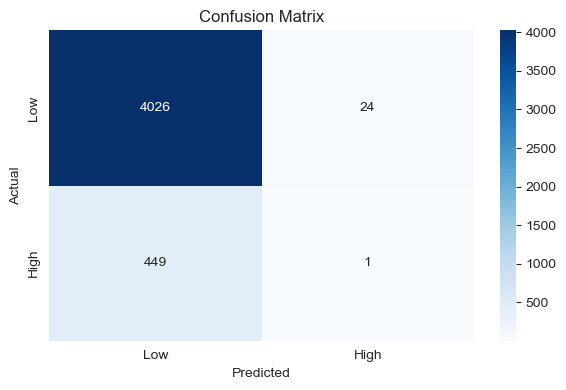

In [15]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='Blues', xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


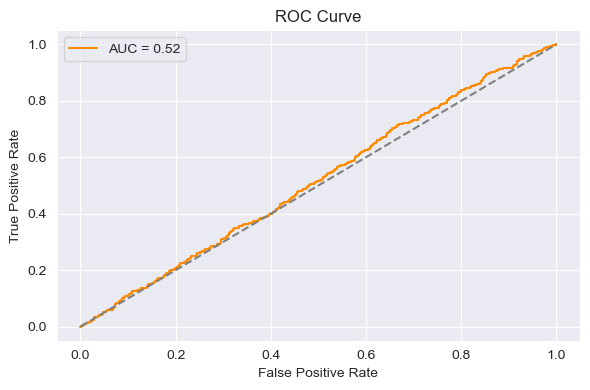

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()
